# Discriminative

Discriminative estimators are mutual information estimators based on the Donsker-Varadhan representation of the KL divergence that describes mutual information:

$$
I(x;y) = KL(p(x,y)||p(x)p(y)) = \text{arg}\!\!\max_{F} \mathbb{E}_{p(x,y)}[F(x,y)] -\log\mathbb{E}_{p(x)p(y)}[e^{F(x,y)}].
$$
We refer to the function $F(x,y)$ as `critic`.

In this example we will train estimators using the two critics to underline the differences.
We start from the definition of the distribution `p(x,y)`

In [1]:
import torch
from torch.distributions import MultivariateNormal, Normal
import warnings
warnings.filterwarnings('ignore')

# Definition of the distribution
p_XY = MultivariateNormal(
    loc=torch.tensor([0., 0.]),
    covariance_matrix=torch.tensor([
        [1.0, 0.99], 
        [0.99, 1.0]
    ])
)
p_X = p_Y = Normal(0, 1)

# I(x;y) = H(x)+H(y)-H(x,y)
true_mi = (
        p_X.entropy() + p_Y.entropy() - p_XY.entropy()
).sum().item()
print(f"True Mutual Information: {true_mi} nats")

# Generate 100000 samples
samples = p_XY.sample([100000])
all_x = samples[:,0]
all_y = samples[:,1]

True Mutual Information: 1.9585182666778564 nats


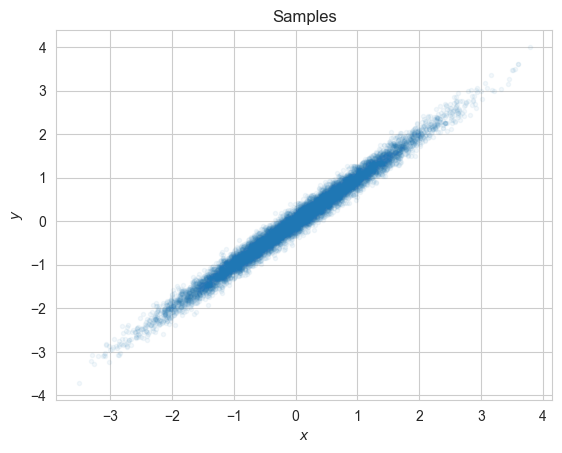

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Plot them
plt.scatter(
    all_x[::10], all_y[::10],
    marker='.',
    alpha=0.05
)
plt.title("Samples")
plt.xlabel('$x$')
plt.ylabel('$y$');

In [ ]:
# We define some fixed parameters for training the estimators
parameters = dict(
    x=all_x,
    y=all_y,
    max_epochs=5,
    batch_size= 128,
    return_log=True,
    verbose=True,
    optimizer_params={'lr':1e-3},
    valid_percentage=0,
    lr_annealing=True,
)

# We define a simple utility function to train all estimators at once
def train_all(estimators):
    log = []
    for name, estimator in estimators.items():
        print(f"Training the {name} estimator")
        start_time = time.time()
        train_log = train_mi_estimator(
            estimator=estimator,
            **parameters
        )
        train_time = time.time()-start_time
        print(f"Train time: {train_time}")
        train_log['model'] = name
        log.append(train_log)
    
    return pd.concat(log)

## Critics
The `torch_mist` package includes two main families of critics: `JointCritic` and `SeparableCritic`, which model $F(x,y)$ directly with a neural network (joint) or as a product of feature extractor networks (separable). The `joint_critic` and `separable_critic` utilities provide a quick way to instantiate critic architectures.
We consider the following critics:

| Critic               | $F(x,y)$                     |
|----------------------|------------------------------|
| Joint                | $F_\theta(x,y)$              | 
| Separable Asymmetric | $f^x_\theta(x)^Tf^y_\phi(y)$ |
| Separable Symmetric  | $f_\theta(x)^Tf_\theta(y)$   |
| Separable One-sided  | $f_\theta(x)^Ty$             |



### Basic

In [3]:
from torch_mist.critic import joint_critic, separable_critic
from torch import nn

x_dim = y_dim = 1

critics ={
    'Joint': joint_critic(
        x_dim=x_dim,
        y_dim=y_dim,
        hidden_dims=[64,32],
        nonlinearity=nn.ReLU()
    ),
    'Separable Asymmetric': separable_critic(
        x_dim=x_dim,
        y_dim=y_dim,
        hidden_dims=[32],
        output_dim=64,
        projection_head='asymmetric',
        nonlinearity=nn.ReLU(),
        temperature=0.1,
        normalize=True
    ),
    'Separable Symmetric': separable_critic(
        x_dim=x_dim,
        y_dim=y_dim,
        hidden_dims=[32],
        output_dim=64,
        projection_head='symmetric',
        nonlinearity=nn.ReLU(),
        temperature=0.1,
        normalize=True
    ),
    'Separable One-Sided': separable_critic(
        x_dim=x_dim,
        y_dim=y_dim,
        hidden_dims=[32, 64],
        projection_head='one',
        nonlinearity=nn.ReLU(),
        temperature=0.1,
        normalize=True
    )
}

for name, critic in critics.items():
    n_params = sum([param.numel() for param in critic.parameters()])
    print(f"{name} critic architecture, {n_params} Parameters")
    print(critic, '\n\n')

Joint critic architecture, 2305 Parameters
JointCritic(
  (joint_net): DenseNN(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
    (f): ReLU()
  )
) 


Separable Asymmetric critic architecture, 4352 Parameters
SeparableCritic(
  (f_x): Sequential(
    (0): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): Linear(in_features=32, out_features=64, bias=True)
      )
      (f): ReLU()
    )
    (1): Normalize()
  )
  (f_y): Sequential(
    (0): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): Linear(in_features=32, out_features=64, bias=True)
      )
      (f): ReLU()
    )
    (1): Normalize()
  )
) 


Separable Symmetric critic architecture, 2176 Parameters
SeparableCritic(
  (f_x): Sequential(
  

We then define and train the two estimators

In [4]:
from torch_mist.estimators import JS
from torch_mist.train import train_mi_estimator
import pandas as pd
import time

neg_samples = 32

estimators = {
    name: JS(
        critic=critic, 
        neg_samples=neg_samples
    ) for name, critic in critics.items()
}

pd_log = train_all(estimators **parameters)

Training the Joint estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 32.15901041030884
Training the Separable Asymmetric estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 33.867167234420776
Training the Separable Symmetric estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 37.96749401092529
Training the Separable One-Sided estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 29.310595989227295


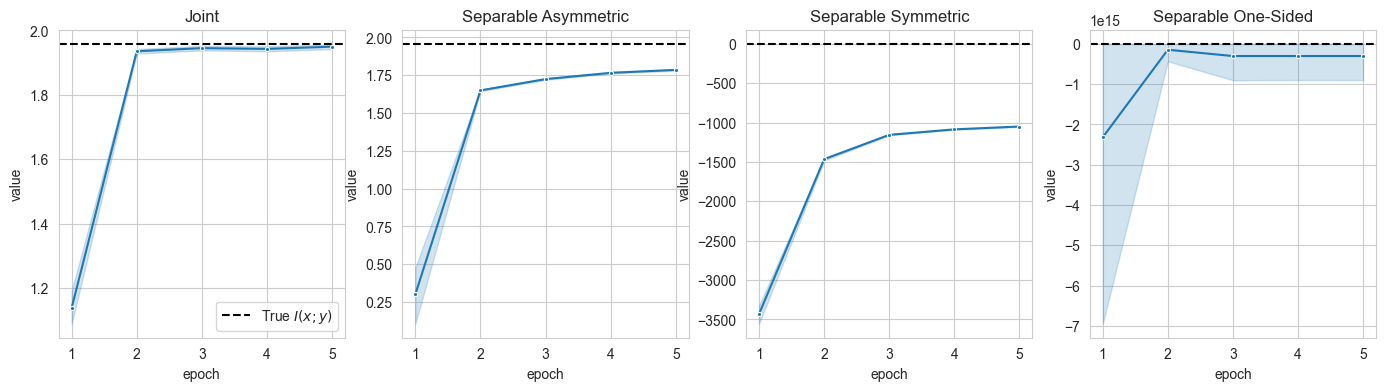

In [5]:
f, ax = plt.subplots(1,len(critics), figsize=(len(critics)*4+1,4))
for i, name in enumerate(estimators):
    ax[i].set_title(name)
    ax[i].axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
    sns.lineplot(pd_log[pd_log['model']==name], x='epoch', y='value', marker='.', ax=ax[i], legend=i==0)

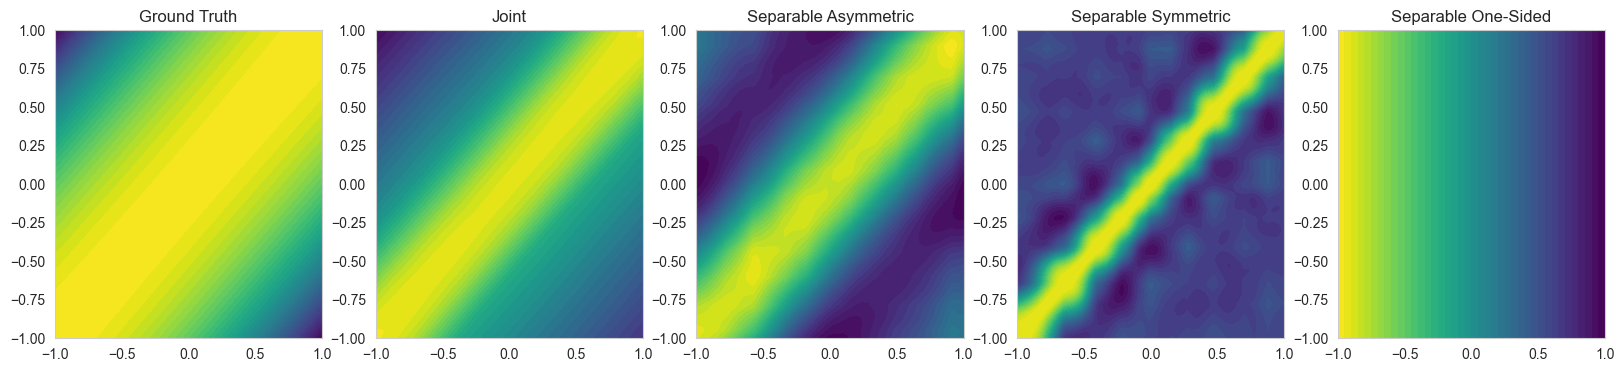

In [6]:
import numpy as np

res = 100

x_grid = torch.linspace(-1,1,res).view(-1,1,1)
y_grid = torch.linspace(-1,1, res).view(1,-1,1)

X, Y = np.meshgrid(x_grid, y_grid)

f, ax = plt.subplots(1,len(critics)+1,figsize=((1+len(critics))*4, 4))

# Compute and visualize the true log ratio log p(x,y)/p(x)p(y)
grid_xy = torch.cat([
    x_grid.repeat(1,res,1),
    y_grid.repeat(res,1,1)
], -1)
log_marginal = p_X.log_prob(x_grid).squeeze(-1) +  p_Y.log_prob(y_grid).squeeze(-1)
log_joint = p_XY.log_prob(grid_xy)
log_ratio = (log_joint - log_marginal).data.numpy()
ax[0].contourf(X, Y, log_ratio, cmap='viridis', levels=40)
ax[0].set_title('Ground Truth')

for i, (name, critic) in enumerate(critics.items()):
    unnormalized_ratio = critic(x_grid, y_grid).data.numpy()
    ax[i+1].contourf(X, Y, unnormalized_ratio, cmap='viridis', levels=40)
    ax[i+1].set_title(name)

We can clearly notice that the separable symmetric and one-sided critic are not sufficiently flexible for accurate mutual information estimation for the given example.

### Advanced

It is possible to manually specify critic architectures by instantiating the `SeparableCritic` and `JointCritic` classes:

In [7]:
from torch_mist.critic import SeparableCritic, JointCritic

# Instantiating a joint critic
j_critic = JointCritic(
    joint_net=nn.Sequential(
        nn.Linear(x_dim+y_dim, 32),
        nn.ReLU(True),
        nn.Linear(32, 32),
        nn.ReLU(True),
        nn.Linear(32, 1)
    )
)

# Instantiating a separable critic
s_critic = SeparableCritic(
    f_x=nn.Sequential(
        nn.Linear(x_dim, 32),
        nn.ReLU(True),
        nn.Linear(32, 64)
    ),
    f_y=nn.Sequential(
        nn.Linear(x_dim, 32),
        nn.ReLU(True),
        nn.Linear(32, 64)
    ),
)


Alternatively, custom critic architectures can be designed by extending the `Critic` base class

In [8]:
from torch_mist.critic import Critic

class MyCustomBilinearCritic(Critic):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        W = torch.zeros(x_dim, y_dim)
        W.normal_()
        self.W = nn.Parameter(W)
    
    def forward(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
    ) -> torch.Tensor:
        # Bilinear product on the last dimension
        return torch.einsum('...x, xy, ...y->...', x, self.W, y)



The custom critic can be used with the other discriminative estimators

In [9]:
custom_critic = MyCustomBilinearCritic(
    x_dim=1,
    y_dim=1,
)        

estimator = JS(critic=custom_critic, neg_samples=neg_samples)
print(estimator)

JS(
  (ratio_estimator): MyCustomBilinearCritic()
  (baseline): ConstantBaseline()
  (neg_samples): 32
)


## Baselines

The discriminative mutual information estimators differ mostly from the strategy used to estimate the log-partition function.
Here, we can use the following inequality:

$$
\log \mathbb{E}_{p(x)p(y)}[e^{F(x,y)}] \le \mathbb{E}_{p(x)p(y)}\left[e^{F(x,y)-b(x)}+b(x)\right]-1
$$
in which we refer to $b(x)$ as `baseline`.
Several estimators in literature can be interpreted by considering different choices of baselines.
E.g. the `NWJ` estimator can be obtained by setting $b(x)=1$, `InfoNCE` by setting $b(x)=\mathbb{E}_{p(y)}\left[e^{F(x,y)}\right]$, `TUBA` uses a learnable parametric baseline $b(x)=b_\psi(x)$, while `MINE` makes use of a running average estimate for training $b(x) = \log EMA(e^{F(x,y)},\gamma)$.

The baselines are summarized in the following table


| Model     | Train $b(x)$                                                              | Evaluation $b(x)$                                  |
|-----------|---------------------------------------------------------------------------|----------------------------------------------------|
| NWJ       | $1$                                                                       | Same as Train                                      |
| MINE      | $\log EMA(\mathbb{E}_{p(x)p(y)}\left[e^{F(x,y)}\right],\gamma)$           | $\log\mathbb{E}_{p(x)p(y)}\left[e^{F(x,y)}\right]$ |
| InfoNCE   | $\log\mathbb{E}_{p(y)}\left[e^{F(x,y)}\right]$                            | Same as Train                                      |
| TUBA      | $b_\psi(x)$                                                               | Same as Train                                      |
| AlphaTuba | $\alpha\log\mathbb{E}_{p(y)}\left[e^{F(x,y)}\right]+(1-\alpha) b_\psi(x)$ | Same as Train                                      | 

in which the expectations are estimated based on a single batch.
Other discriminative estimator such as `JS`, `SMILE` and `FLO` use a slightly different objective for training.


`torch_mist` already provides implementations of the aforementioned estimators, but different baselines can be instantiated easily.

In [10]:
from torch_mist.estimators import BaselineDiscriminativeMIEstimator
from torch_mist.baselines import ConstantBaseline, ExponentialMovingAverage, baseline_nn, InterpolatedBaseline
from copy import deepcopy

# We instantiate a simple joint critic
critic = joint_critic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64,32],
    nonlinearity=nn.ReLU()
)

# And some example baselines
baselines = {
    'Constant': ConstantBaseline(1),                        # NWJ baseline
    'EMA': ExponentialMovingAverage(gamma=0.9),             # MINE baseline (training)
    'Learnable': baseline_nn(                               # TUBA baseline
        x_dim=x_dim,
        hidden_dims=[32, 32],    
    ),
    'Interpolated': InterpolatedBaseline(                   # AlphaTUBA baseline
        baseline_1=ExponentialMovingAverage(gamma=0.9),     # Custom interpolated baseline 
        baseline_2=baseline_nn(                             
            x_dim=x_dim,
            hidden_dims=[32, 32],    
        ),
        alpha=0.5
    )
}

# The BaselineDiscriminativeMIEstimator class allows us to specify a train and evaluation baseline
estimators = {
    name: BaselineDiscriminativeMIEstimator(
        critic=deepcopy(critic),
        baseline=baseline,
        neg_samples=neg_samples
    )
    for name, baseline in baselines.items()
}


for name, baseline in baselines.items():
    print(f"{name} baseline architecture, {sum([param.numel() for param in baseline.parameters()])} Parameters")
    print(baseline, '\n')

Constant baseline architecture, 0 Parameters
ConstantBaseline() 

EMA baseline architecture, 0 Parameters
ExponentialMovingAverage() 

Learnable baseline architecture, 1153 Parameters
LearnableBaseline(
  (net): DenseNN(
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
    (f): ReLU(inplace=True)
  )
) 

Interpolated baseline architecture, 1153 Parameters
InterpolatedBaseline(
  (baseline_1): ExponentialMovingAverage()
  (baseline_2): LearnableBaseline(
    (net): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): Linear(in_features=32, out_features=32, bias=True)
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
      (f): ReLU(inplace=True)
    )
  )
) 


In [11]:
# We can train all the estimators
pd_log = train_all(estimators)

Training the Constant estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 27.30623698234558
Training the EMA estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 32.43813157081604
Training the Learnable estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 38.297653913497925
Training the Interpolated estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 40.61889386177063


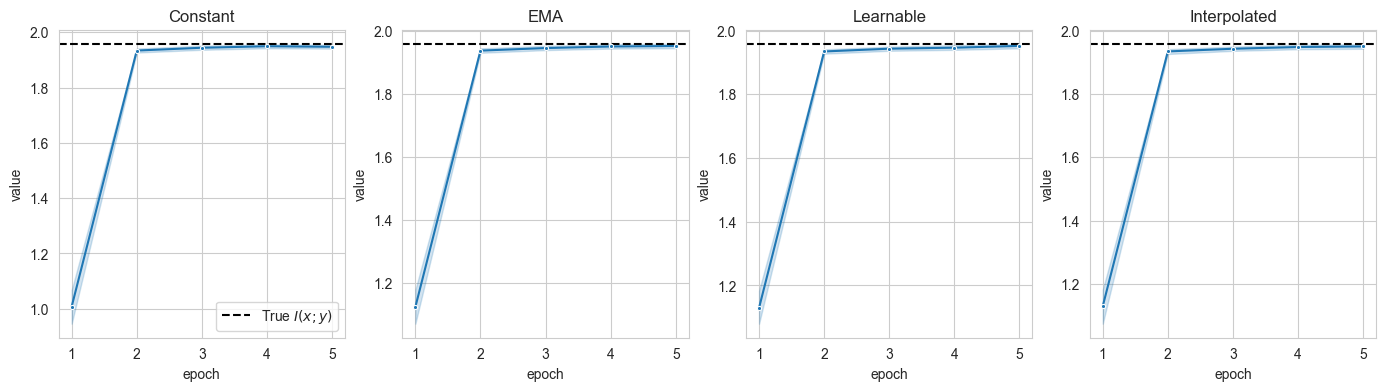

In [12]:
f, ax = plt.subplots(1,len(critics), figsize=(len(critics)*4+1,4))
for i, name in enumerate(estimators):
    ax[i].set_title(name)
    ax[i].axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
    sns.lineplot(pd_log[pd_log['model']==name], x='epoch', y='value', marker='.', ax=ax[i], legend=i==0)

## Number of Negative Samples

As shown above, estimating the log-partition function requires evaluating $\mathbb{E}_{p(x)p(y)}\left[e^{F(x,y)-b(x)}+b(x)\right]$.
We consider Monte Carlo estimate based on minibatches of $N$ pairs of pairs $(x_i,y_i)$ iid sampled from $p(x,y)$.
Note that because of the iid assumption, the pair $(x_i,y_j)$ for $i\neq j$ can be considered as a sample from $p(x)p(y)$.

The parameter 'neg_samples' regulates how many $y_j$ are used for each $x_i$ in the batch for the estimation of the expectation above.
Let $M=$ 'neg_samples' then:

$$
\mathbb{E}_{p(x)p(y)}\left[e^{F(x,y)-b(x)}+b(x)\right]\approx \frac{1}{N}\sum_{i=1}^N b(x_i) + \frac{1}{M}\sum_{j=1}^M e^{F(x_i,y_{(i+j)\!\!\!\!\!\!\!\!\!\mod N})}
$$
in which $(i+j)\!\!\!\!\!\!\!\!\!\mod{N}$ is used to select the first $M$ elements starting from $i+1$, looping around for $i+j>N$.

The value of `neg_samples` has to be less than the `batch_size`. A value of `neg_samples=0` is used to specify that the summation over $j$ should go over the whole batch (including $i=j$), negative values are used to specify the number of relative negative samples with respect to the current batch size.
E.g. `neg_samples=-10` will use `batch_size-10` negative samples for each $x_i$.

Note that the number of negative samples has a strong effect on the memory usage, computational cost for training and evaluation, and the variance and convergence speed of the estimators. More negative samples increase the costs but improve the quality of the estimation


In [13]:
from torch_mist.estimators.discriminative import NWJ

# Instantiate NWJ estimators based on the same critic with different numbers of negatives
estimators = {
    f"{n} negative samples": NWJ(deepcopy(critic), neg_samples=n) for n in 4**np.arange(4)
}

# We can train all the estimators
pd_log = train_all(estimators)

Training the 1 negative samples estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 28.159629821777344
Training the 4 negative samples estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 24.47205662727356
Training the 16 negative samples estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 26.912482500076294
Training the 64 negative samples estimator


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Train time: 37.1834454536438


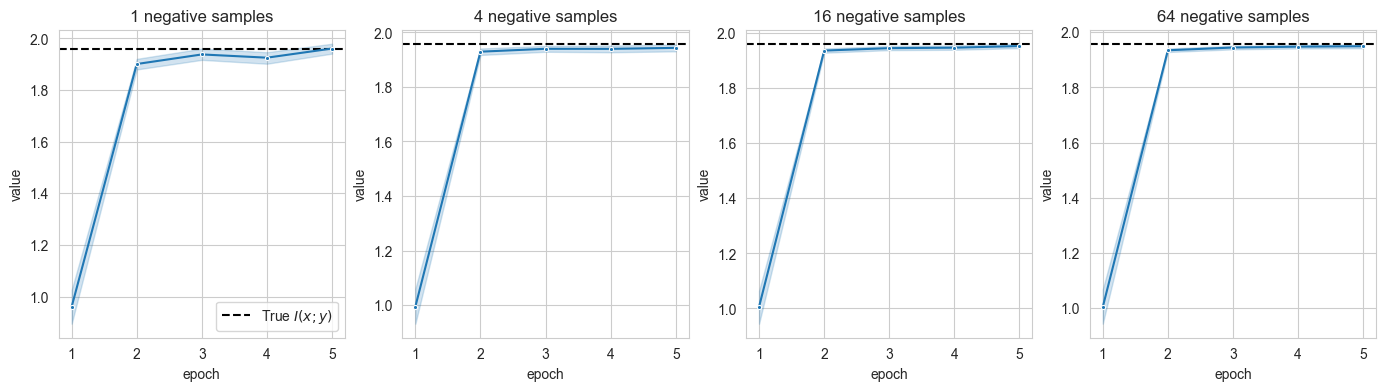

In [14]:
f, ax = plt.subplots(1,len(critics), figsize=(len(critics)*4+1,4))
for i, name in enumerate(estimators):
    ax[i].set_title(name)
    ax[i].axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
    sns.lineplot(pd_log[pd_log['model']==name], x='epoch', y='value', marker='.', ax=ax[i], legend=i==0)